In [98]:
import pickle
import re

import math
import random
import numpy as np
from collections import Counter
from keras.models import Model
from keras.layers import Input, Dense, GRU, TimeDistributed, Concatenate
from keras.utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from scipy.ndimage.interpolation import shift
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '../src/')
import kernel_util

In [3]:
# Remove when done with kernel
import importlib
importlib.reload(kernel_util)

<module 'kernel_util' from '../1. Data Preparation/src/kernel_util.py'>

In [4]:
### Load data ###
chords_f0s_beats = pickle.load(open("../src/chords-f0s-beats.pkl", 'rb'))
chords = [part["chords"] for sid, song in chords_f0s_beats.items() for part in song]
f0s = [part["f0s"] for sid, song in chords_f0s_beats.items() for part in song]
beats = [part["beats"] for sid, song in chords_f0s_beats.items() for part in song]

In [5]:
### Train/Test splitting ###
indices = [145, 92, 112, 161, 24, 266, 21, 83, 308, 246, 326, 126, 332, 65, 247, 263, 294, 68, 313, 156, 143, 344, 62, 210, 39, 84, 340, 134, 274, 257, 167, 48, 299, 102, 11, 331, 181, 214, 18, 90, 225, 82, 286, 56, 71, 153, 251, 256, 237, 287, 80, 137, 14, 131, 115, 309, 254, 273, 6, 307, 269, 315, 87, 19, 22, 125, 49, 305, 2, 133, 136, 250, 335, 334, 229, 105, 146, 47, 185, 107, 228, 261, 338, 322, 330, 123, 12, 94, 191, 292, 76, 135, 304, 122, 204, 333, 194, 291, 317, 60, 152, 61, 179, 173, 158, 280, 13, 336, 283, 195, 244, 85, 1, 8, 242, 119, 45, 255, 114, 279, 4, 74, 116, 52, 36, 215, 290, 197, 132, 258, 140, 139, 276, 206, 319, 342, 63, 20, 186, 168, 328, 303, 144, 138, 16, 199, 155, 213, 311, 264, 183, 30, 130, 55, 7, 108, 109, 5, 234, 190, 148, 217, 44, 298, 159, 265, 323, 154, 272, 151, 252, 118, 288, 23, 70, 216, 104, 9, 3, 64, 42, 262, 172, 259, 128, 211, 142, 275, 184, 223, 96, 219, 327, 343, 178, 300, 171, 243, 226, 166, 17, 41, 165, 189, 238, 175, 25, 72, 86, 35, 124, 37, 15, 177, 32, 297, 203, 77, 278, 33, 75, 157, 170, 147, 117, 34, 236, 120, 193, 221, 341, 73, 51, 57, 78, 110, 27, 224, 188, 282, 182, 271, 29, 239, 222, 40, 232, 296, 43, 218, 100, 293, 312, 201, 241, 150, 200, 233, 248, 281, 306, 97, 98, 28, 160, 10, 88, 207, 249, 66, 277, 240, 270, 95, 337, 163, 314, 99, 231, 162, 329, 38, 176, 267, 316, 198, 192, 202, 245, 196, 268, 111, 129, 0, 285, 164, 227, 209, 324, 54, 212, 289, 59, 31, 89, 220, 113, 301, 339, 208, 106, 180, 81, 67, 53, 79, 69, 46, 318, 310, 169, 127, 230, 50, 141, 26, 302, 260, 103, 187, 321, 295, 91, 149, 101, 205, 320, 93, 253, 325, 174, 121, 235, 284, 58]

train_indices = indices[0:round(len(chords)*0.75)]
test_indices = indices[round(len(chords)*0.75):]

chords_train = [chords[i] for i in train_indices]
chords_test = [chords[i] for i in test_indices]
f0s_train = [f0s[i] for i in train_indices]
f0s_test = [f0s[i] for i in test_indices]
beats_train = [beats[i] for i in train_indices]
beats_test = [beats[i] for i in test_indices]

In [6]:
### Preprocess data ###
# i.e. get all song section data split in beats altogether in a common list of list

# Train data
part_chords_train = []
part_f0_seqs_train = []
for (part_c, part_f, part_b) in zip(chords_train, f0s_train, beats_train):
    part_f0_seqs, part_chords = kernel_util.split_in_beats(part_c, part_f, part_b)
    part_chords_train.append([kernel_util.truncate_chord_to_triad_rwc(chord) for chord in part_chords])
    part_f0_seqs_train.append(part_f0_seqs)
    
# Test data
part_chords_test = []
part_f0_seqs_test = []
for (part_c, part_f, part_b) in zip(chords_test, f0s_test, beats_test):
    part_f0_seqs, part_chords = kernel_util.split_in_beats(part_c, part_f, part_b)
    part_chords_test.append([kernel_util.truncate_chord_to_triad_rwc(chord) for chord in part_chords])
    part_f0_seqs_test.append(part_f0_seqs)

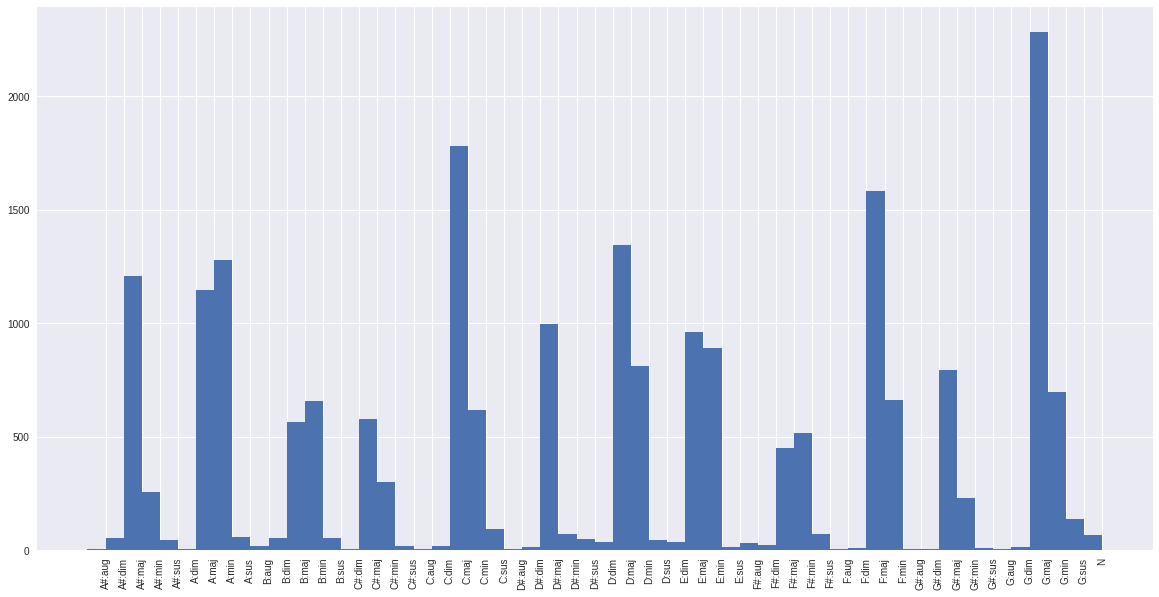

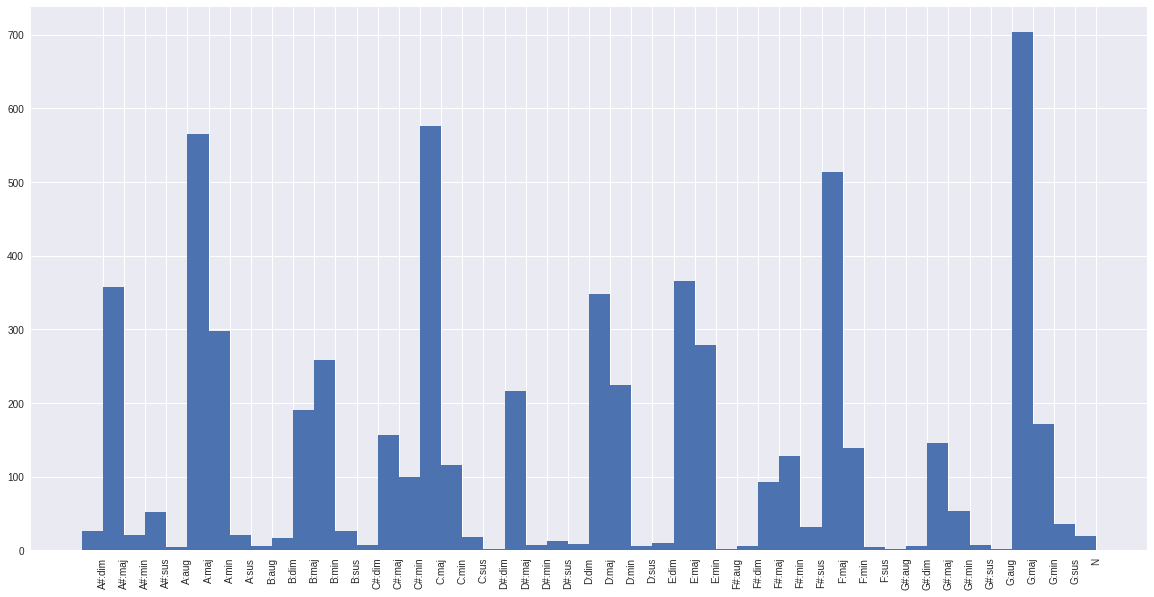

In [7]:
### Train/Test set basic statistics ###

# Chords in train set
all_chords_train = [chord for part in part_chords_train for chord in part]
cnt = Counter()
for ch in all_chords_train:
    cnt[ch] += 1

labels, values = zip(*cnt.items())
labels, values = zip(*sorted(zip(labels, values)))
indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation='vertical')
plt.show()



# Chords in test set
all_chords_test = [chord for part in part_chords_test for chord in part]
cnt = Counter()
for ch in all_chords_test:
    cnt[ch] += 1

labels, values = zip(*cnt.items())
labels, values = zip(*sorted(zip(labels, values)))
indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(20,10))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation='vertical')
plt.show()

In [8]:
### Target classes mapping ###
total_chords = []
for part in chords:
    for chord in part:
        total_chords.append(kernel_util.truncate_chord_to_triad_rwc(chord))

distinct_target = list(set(total_chords))
chords_label_index = dict(
    [(c, i) for i, c in enumerate(sorted(distinct_target))])
chords_label_index['START'] = len(chords_label_index)
# chords_label_index['END'] = len(chords_label_index)
print(chords_label_index)
mapping_to_chord = {}
for k, v in chords_label_index.items():
    mapping_to_chord[v] = k

{'A:aug': 5, 'E:dim': 33, 'F:maj': 44, 'C#:sus': 18, 'F#:sus': 41, 'D#:dim': 25, 'C#:min': 17, 'G:min': 55, 'A:dim': 6, 'D#:sus': 28, 'C:min': 22, 'A:min': 8, 'E:min': 35, 'F#:aug': 37, 'B:sus': 14, 'F#:min': 40, 'G#:maj': 49, 'G#:min': 50, 'C:dim': 20, 'D:sus': 32, 'F:dim': 43, 'F#:maj': 39, 'A#:sus': 4, 'F:min': 45, 'F:aug': 42, 'C:sus': 23, 'A#:aug': 0, 'G:aug': 52, 'C#:maj': 16, 'C:maj': 21, 'A#:maj': 2, 'A#:min': 3, 'G#:aug': 47, 'B:maj': 12, 'START': 58, 'D:maj': 30, 'B:min': 13, 'G:sus': 56, 'D#:min': 27, 'D#:aug': 24, 'A:maj': 7, 'E:maj': 34, 'C:aug': 19, 'A#:dim': 1, 'A:sus': 9, 'G#:sus': 51, 'F:sus': 46, 'G#:dim': 48, 'C#:dim': 15, 'N': 57, 'G:dim': 53, 'F#:dim': 38, 'D:dim': 29, 'D#:maj': 26, 'B:dim': 11, 'G:maj': 54, 'B:aug': 10, 'D:min': 31, 'E:sus': 36}


In [9]:
### Variables definition ###
num_parts_train = len(part_f0_seqs_train)
num_parts_test = len(part_f0_seqs_test)
max_num_beats = max([len(part) for part in part_f0_seqs_train+part_f0_seqs_test])
max_num_samples = max([len(beat_seq) for part in part_f0_seqs_train+part_f0_seqs_test for beat_seq in part])
num_input_features = 1
num_target_classes = len(chords_label_index)
look_back = 10

print("Total number of input train samples:", num_parts_train)
print("Total number of input test samples:", num_parts_test)
print("Maximum beat sequence length by parts:", max_num_beats)
print("Maximum sample sequence length by beats:", max_num_samples)
print("Size of input feature vector:", num_input_features)
print("Number of target classes:", num_target_classes)
print("Length of past sequence encoded for next chord prediction:", look_back)

Total number of input train samples: 259
Total number of input test samples: 86
Maximum beat sequence length by parts: 402
Maximum sample sequence length by beats: 97
Size of input feature vector: 1
Number of target classes: 59
Length of past sequence encoded for next chord prediction: 10


In [10]:
def normalize(f):
    if not f == 0:
        f_log = math.log(f)
    else:
        f_log = 0.0
    min_f_log = math.log(8.1757989156, 10)
    max_f_log = math.log(12543.8539514160, 10)
    z = (f_log - min_f_log)/(max_f_log-min_f_log)
    return z

In [11]:
### Build tensors ###

# Initialize tensors
pitch_input_train = np.zeros(
    (num_parts_train, max_num_beats, max_num_samples, num_input_features), # add two rows for the padding class and for the duration metric
#     fill_value=-1,
    dtype='float32')
chord_input_train = np.zeros(
    (num_parts_train, max_num_beats, look_back, num_target_classes), # add two rows for the padding class and for the duration metric
#     fill_value=chords_label_index['N'],
    dtype='float32')
chord_target_train = np.zeros(
    (num_parts_train, max_num_beats, num_target_classes), # add two rows for the padding class and for the duration metric
#     fill_value=chords_label_index['N'],
    dtype='float32')

pitch_input_test = np.zeros(
    (num_parts_test, max_num_beats, max_num_samples, num_input_features), # add two rows for the padding class and for the duration metric
#     fill_value=-1,
    dtype='float32')
chord_input_test = np.zeros(
    (num_parts_test, max_num_beats, look_back, num_target_classes), # add two rows for the padding class and for the duration metric
#     fill_value=chords_label_index['N'],
    dtype='float32')
chord_target_test = np.zeros(
    (num_parts_test, max_num_beats, num_target_classes), # add two rows for the padding class and for the duration metric
#     fill_value=chords_label_index['N'],
    dtype='float32')

# Fill tensors
for i, (part_c, part_f) in enumerate(zip(part_chords_train, part_f0_seqs_train)):
    # fill pitch input tensor
    for j, beat_f in enumerate(part_f):        
        for k, f in enumerate(beat_f):
            pitch_input_train[i, j, k, 0] = f
    # fill chord input and target tensors
    chord_sequence = look_back*['START'] + part_c
    for j, chord in enumerate(part_c):
        chord_target_train[i, j, chords_label_index[chord]] = 1
        for k in range(look_back):
            chord_input_train[i, j, k, chords_label_index[chord_sequence[j+k]]] = 1
        
for i, (part_c, part_f) in enumerate(zip(part_chords_test, part_f0_seqs_test)):
    # fill pitch input tensor
    for j, beat_f in enumerate(part_f):        
        for k, f in enumerate(beat_f):
            pitch_input_test[i, j, k, 0] = f
    # fill chord input and target tensors
    chord_sequence = look_back*['START'] + part_c
    for j, chord in enumerate(part_c):
        chord_target_test[i, j, chords_label_index[chord]] = 1
        for k in range(look_back):
            chord_input_test[i, j, k, chords_label_index[chord_sequence[j+k]]] = 1

In [12]:
print(chord_input_train.shape)

(259, 402, 10, 59)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, 97, 1)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, None, 10, 59)  0                                            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, None, 128)     49920       input_1[0][0]                    
____________________________________________________________________________________________________
time_distributed_2 (TimeDistribu (None, None, 128)     72192       input_2[0][0]                    
___________________________________________________________________________________________

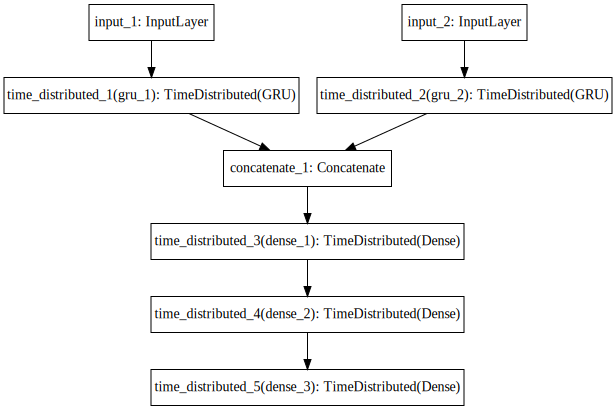

In [13]:
### Build model ### <- Original model

hidden_units_pitch = 128
hidden_units_chord = 128
hidden_units_dense = 128

pitch_inputs = Input(shape=(None, max_num_samples, num_input_features))
pitch_gru = TimeDistributed(GRU(hidden_units_pitch))(pitch_inputs)

chord_inputs = Input(shape=(None, look_back, num_target_classes))
chord_gru = TimeDistributed(GRU(hidden_units_chord))(chord_inputs)

concat = Concatenate()([pitch_gru, chord_gru])

dense1 = TimeDistributed(Dense(hidden_units_dense, activation="relu"))(concat)
dense2 = TimeDistributed(Dense(hidden_units_dense, activation="relu"))(dense1)
prediction = TimeDistributed(Dense(num_target_classes, activation='softmax'))(dense2)

model = Model([pitch_inputs, chord_inputs], prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
### Train model ### <- Original cell
batch_size = 1
epochs = 150
history = model.fit([pitch_input_train, chord_input_train], chord_target_train, validation_data=([pitch_input_test, chord_input_test], chord_target_test), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 259 samples, validate on 86 samples
Epoch 1/150
259/259 [==============================] - 28s - loss: 0.5618 - acc: 0.0772 - val_loss: 0.3292 - val_acc: 0.1149
Epoch 2/150
259/259 [==============================] - 27s - loss: 0.3444 - acc: 0.1349 - val_loss: 0.2778 - val_acc: 0.1220
Epoch 3/150
259/259 [==============================] - 27s - loss: 0.3129 - acc: 0.1386 - val_loss: 0.2639 - val_acc: 0.1233
Epoch 4/150
259/259 [==============================] - 27s - loss: 0.2959 - acc: 0.1402 - val_loss: 0.2635 - val_acc: 0.1233
Epoch 5/150
259/259 [==============================] - 27s - loss: 0.2817 - acc: 0.1419 - val_loss: 0.2471 - val_acc: 0.1247
Epoch 6/150
259/259 [==============================] - 27s - loss: 0.2701 - acc: 0.1425 - val_loss: 0.2396 - val_acc: 0.1246
Epoch 7/150
259/259 [==============================] - 27s - loss: 0.2608 - acc: 0.1436 - val_loss: 0.2335 - val_acc: 0.1243
Epoch 8/150
259/259 [==============================] - 27s - loss: 0.2536 - acc:

259/259 [==============================] - 27s - loss: 0.0238 - acc: 0.1999 - val_loss: 0.2769 - val_acc: 0.1455
Epoch 130/150
259/259 [==============================] - 27s - loss: 0.0223 - acc: 0.2004 - val_loss: 0.2749 - val_acc: 0.1456
Epoch 131/150
259/259 [==============================] - 27s - loss: 0.0232 - acc: 0.2000 - val_loss: 0.2788 - val_acc: 0.1455
Epoch 132/150
259/259 [==============================] - 27s - loss: 0.0221 - acc: 0.2003 - val_loss: 0.2853 - val_acc: 0.1443
Epoch 133/150
259/259 [==============================] - 27s - loss: 0.0223 - acc: 0.2005 - val_loss: 0.2890 - val_acc: 0.1445
Epoch 134/150
259/259 [==============================] - 27s - loss: 0.0236 - acc: 0.2001 - val_loss: 0.2814 - val_acc: 0.1454
Epoch 135/150
259/259 [==============================] - 27s - loss: 0.0227 - acc: 0.2003 - val_loss: 0.2820 - val_acc: 0.1452
Epoch 136/150
259/259 [==============================] - 27s - loss: 0.0235 - acc: 0.2002 - val_loss: 0.2871 - val_acc: 0.144

In [20]:
### Save/Load weights ###
model.save_weights('rawF0 - HGRU [GRU(128), GRU(128)]->Concat->Dense(128)->Dense(128)->Dense(classes)-2.h5')
# model.load_weights('rawF0 - HGRU [GRU(128), GRU(128)]->Concat->Dense(128)->Dense(128)->Dense(classes).h5')

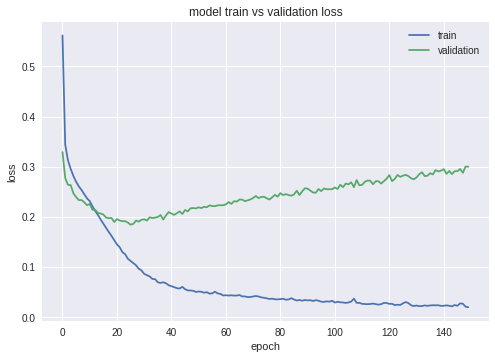

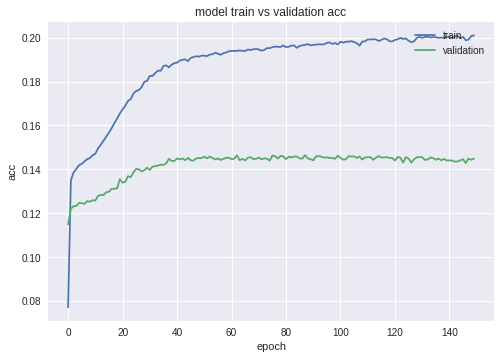

In [16]:
### Visualize learning ###
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [17]:
def generate_chord_sequence(input_seq):
    
    # Initial chord tensor
    chord_input_predict = np.zeros((1, 1, look_back, num_target_classes), dtype='float32')
    for k in range(look_back):
        chord_input_predict[0, 0, k, chords_label_index['START']] = 1
    
    # Generate chord sequence
    predicted_chords = []
    for beat_f in sample_f0_seqs:
        pitch_input_predict = np.zeros((1, 1, max_num_samples, num_input_features), dtype='float32')
        for j, sample_f in enumerate(beat_f):        
            pitch_input_predict[0, 0, j, 0] = sample_f

        prediction_array = model.predict([pitch_input_predict, chord_input_predict], batch_size=1)
        index = np.argmax(prediction_array)
        predicted_chord = mapping_to_chord[index]
        predicted_chords.append(predicted_chord)

        # Update input chord tensor
        current_look_back = chord_input_predict
        chord_input_predict = np.zeros((1, 1, look_back, num_target_classes), dtype='float32')
        for k in range(look_back-1):
            chord_input_predict[0, 0, k] = current_look_back[0, 0, k+1]
        chord_input_predict[0, 0, look_back-1, index] = 1

    return predicted_chords

In [92]:
### Chord generation ###

# Randomly pick song part
# sample_index = random.randint(0, len(test_indices))
for i in range(0, len(test_indices)):
    sample_ch, sample_f0, sample_bt = chords_test[i], f0s_test[i], beats_test[i]
    sample_f0_seqs, sample_chords = kernel_util.split_in_beats(sample_ch, sample_f0, sample_bt)
    print(len(sample_f0_seqs), len(sample_chords))
#     sample_chords = [kernel_util.truncate_chord_to_triad_rwc(chord) for chord in sample_chords]
#     if len(sample_chords)==120:
#         print(i)
        
sample_index = -9
sample_ch, sample_f0, sample_bt = chords_test[sample_index], f0s_test[sample_index], beats_test[sample_index]
sample_f0_seqs, sample_chords = kernel_util.split_in_beats(sample_ch, sample_f0, sample_bt)
sample_chords = [kernel_util.truncate_chord_to_triad_rwc(chord) for chord in sample_chords]
print("Sequence length:", len(sample_chords))

predicted_chords = generate_chord_sequence(sample_f0_seqs)
print("Groundtruth, Prediction")
for true, pred in zip(sample_chords, predicted_chords):
    print(true, pred)


86 86
99 99
72 72
73 73
128 128
62 62
106 106
36 36
10 10
37 37
135 135
57 57
62 62
158 158
65 65
100 100
14 14
136 136
73 73
5 5
61 61
29 29
209 209
60 60
13 13
42 42
103 103
73 73
74 74
81 81
10 10
13 13
9 9
34 34
197 197
45 45
77 77
92 92
10 10
105 105
73 73
97 97
12 12
29 29
192 192
172 172
53 53
81 81
188 188
8 8
11 11
12 12
30 30
50 50
70 70
169 169
13 13
64 64
82 82
44 44
80 80
133 133
184 184
92 92
97 97
74 74
159 159
168 168
13 13
11 11
104 104
15 15
45 45
130 130
13 13
12 12
67 67
83 83
162 162
4 4
67 67
110 110
116 116
69 69
13 13
27 27
Sequence length: 83
Groundtruth, Prediction
B:maj C:maj
B:maj C:maj
B:maj C:maj
B:maj C:maj
B:maj C:maj
E:maj C:maj
E:maj C:maj
E:maj C:maj
E:maj D:min
E:maj D:min
E:maj D:min
E:maj D:min
E:maj A#:maj
E:maj A#:maj
D:maj A#:maj
D:maj A#:maj
D:maj C:maj
C#:min C:maj
C#:min C:maj
C#:min C:maj
C#:min G:maj
C#:min G:maj
G#:min G:maj
G#:min G:maj
G#:min A#:maj
C#:min A#:maj
C#:min A#:maj
C#:min A#:maj
E:maj G:maj
E:maj G:maj
F#:min G:maj
F#:min G:m

In [93]:
# ### Performance evaluation ###

# # for each song part
# # generate chords
# # save predicted and groundtruth chords in a list
# # convert list to ints
# # create confusion matrix

groundtruths = []
predictions = []
for test_index in range(len(test_indices)):
    sample_ch, sample_f0, sample_bt = chords_test[test_index], f0s_test[test_index], beats_test[test_index]
    sample_f0_seqs, sample_chords = kernel_util.split_in_beats(sample_ch, sample_f0, sample_bt)
    sample_chords = [kernel_util.truncate_chord_to_triad_rwc(chord) for chord in sample_chords]
    chord_seq_prediction = generate_chord_sequence(sample_f0_seqs)
    predictions += chord_seq_prediction
    groundtruths += sample_chords

/home/maxime/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


ValueError: At least one label specified must be in y_true

In [119]:
### Error analysis ###
groundtruths_ints = [entry for entry in groundtruths]
predictions_ints = [entry for entry in predictions]
labels = sorted(chords_label_index.keys())
cm = confusion_matrix(groundtruths_ints, predictions_ints, labels)

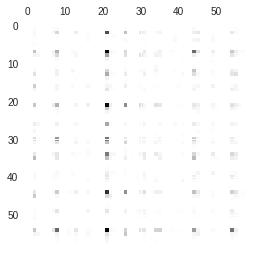

In [100]:
fig = plt.figure(figsize=(4, 5), dpi=100)
plt.matshow(conf_matrix)

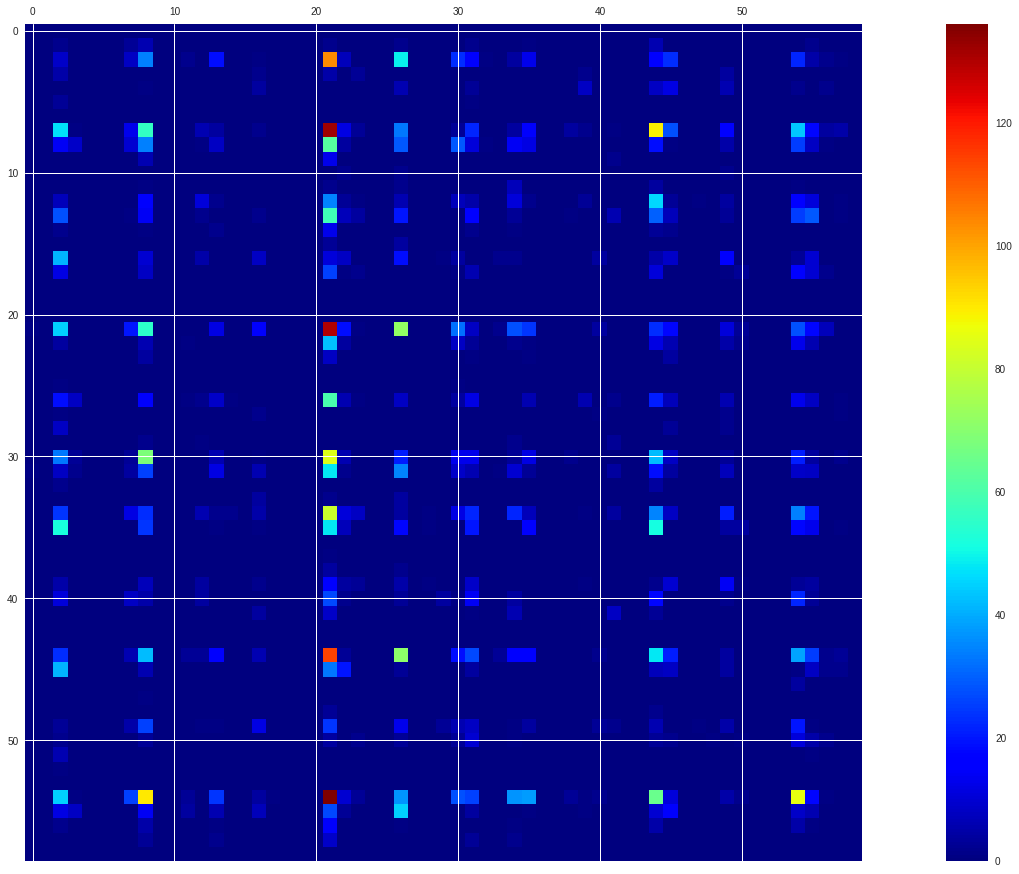

In [135]:
plt.figure(figsize=(30,15))
plt.matshow(conf_matrix, fignum=1,cmap=plt.cm.jet)
plt.colorbar()
plt.show()
